In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from itertools import product
from fbprophet import Prophet

import gc
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

Importing plotly failed. Interactive plots will not work.


## 载入数据

In [2]:
path = './data/'
balance_user = pd.read_csv(path + 'user_balance_table.csv').sort_values(['user_id', 'report_date']).reset_index(drop=True)
balance_user['report_date'] = pd.to_datetime(balance_user['report_date'].astype(str))
balance_user.head()

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,2014-03-20,20111,0,20111,20111,0,20111,0,0,0,0,0,0,NaN,NaN,NaN,NaN
1,1,2014-03-21,20111,20111,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2,1,2014-03-22,20113,20111,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,2014-03-23,20115,20113,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,2014-03-24,20117,20115,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN


In [3]:
train = balance_user.groupby('report_date')['total_purchase_amt', 'total_redeem_amt'].sum()
train.head()

,total_purchase_amt,total_redeem_amt
report_date,,
2013-07-01,32488348,5525022
2013-07-02,29037390,2554548
2013-07-03,27270770,5953867
2013-07-04,18321185,6410729
2013-07-05,11648749,2763587


In [4]:
pd.date_range('2013-7-1', '2014-8-31', freq='m')

DatetimeIndex(['2013-07-31', '2013-08-31', '2013-09-30', '2013-10-31',
               '2013-11-30', '2013-12-31', '2014-01-31', '2014-02-28',
               '2014-03-31', '2014-04-30', '2014-05-31', '2014-06-30',
               '2014-07-31', '2014-08-31'],
              dtype='datetime64[ns]', freq='M')

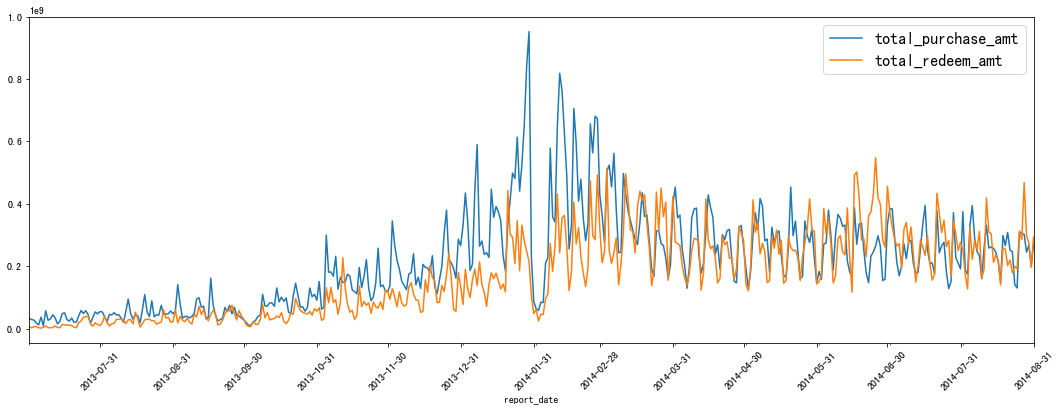

In [5]:
plt.figure(figsize=(18,6))
train['total_purchase_amt'].plot()
train['total_redeem_amt'].plot()
plt.xticks(pd.date_range('2013-7-1', '2014-8-31', freq='m'), map(lambda t: t.strftime('%Y-%m-%d'), pd.date_range('2013-7-1', '2014-8-31', freq='m')), rotation=45)
plt.legend(fontsize=16)

### prophet模型拟合与预测

### total_purchase_amt

In [6]:
purchase = train[['total_purchase_amt']]
purchase.reset_index(inplace=True)
purchase.columns = ['ds', 'y']
purchase.head(3)

,ds,y
0,2013-07-01,32488348
1,2013-07-02,29037390
2,2013-07-03,27270770


In [7]:
alg_purchase = Prophet(growth='linear', yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False,
                       seasonality_prior_scale=1)
# alg_purchase.add_seasonality('monthly', period=30.5, fourier_order=2)
alg_purchase.fit(purchase)

In [8]:
future_purchase = alg_purchase.make_future_dataframe(30)
forcast_purchase = alg_purchase.predict(future_purchase)
forcast_purchase.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-07-01,-1.694359e+07,-1.012699e+08,1.388406e+08,-1.694359e+07,-1.694359e+07,4.511864e+07,4.511864e+07,4.511864e+07,4.511864e+07,4.511864e+07,4.511864e+07,0.0,0.0,0.0,2.817505e+07
1,2013-07-02,-1.577043e+07,-8.308919e+07,1.504058e+08,-1.577043e+07,-1.577043e+07,4.782961e+07,4.782961e+07,4.782961e+07,4.782961e+07,4.782961e+07,4.782961e+07,0.0,0.0,0.0,3.205918e+07
2,2013-07-03,-1.459727e+07,-9.327179e+07,1.330579e+08,-1.459727e+07,-1.459727e+07,3.786657e+07,3.786657e+07,3.786657e+07,3.786657e+07,3.786657e+07,3.786657e+07,0.0,0.0,0.0,2.326929e+07


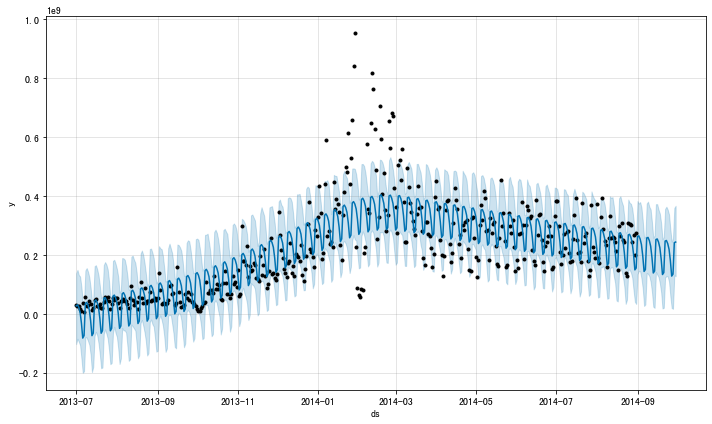

In [9]:
alg_purchase.plot(forcast_purchase);

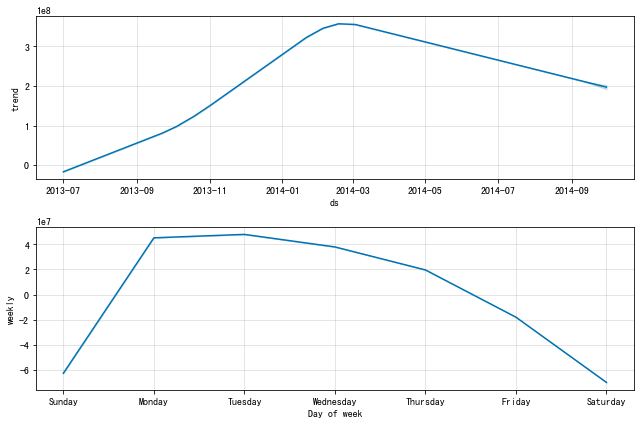

In [10]:
alg_purchase.plot_components(forcast_purchase);

In [11]:
pre_purchase = forcast_purchase[forcast_purchase['ds'] >= '2014-09-01'][['ds', 'yhat']]
pre_purchase.rename(columns={'yhat': 'purchase'}, inplace=True)
pre_purchase.head(3)

,ds,purchase
427,2014-09-01,2.638201e+08
428,2014-09-02,2.657807e+08
429,2014-09-03,2.550672e+08


### total_redeem_amt

In [12]:
redeem = train[['total_redeem_amt']]
redeem.reset_index(inplace=True)
redeem.columns = ['ds', 'y']
redeem.head(3)

,ds,y
0,2013-07-01,5525022
1,2013-07-02,2554548
2,2013-07-03,5953867


In [13]:
alg_redeem = Prophet(growth='linear', yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False,
                       seasonality_prior_scale=1)
# alg_redeem.add_seasonality('monthly', period=30.5, fourier_order=2)
alg_redeem.fit(redeem)

In [14]:
future_redeem = alg_redeem.make_future_dataframe(30)
forcast_redeem = alg_redeem.predict(future_redeem)
forcast_redeem.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-07-01,-2.505548e+07,-6.325607e+07,1.059818e+08,-2.505548e+07,-2.505548e+07,4.935736e+07,4.935736e+07,4.935736e+07,4.935736e+07,4.935736e+07,4.935736e+07,0.0,0.0,0.0,2.430188e+07
1,2013-07-02,-2.417503e+07,-8.126952e+07,8.630345e+07,-2.417503e+07,-2.417503e+07,2.293310e+07,2.293310e+07,2.293310e+07,2.293310e+07,2.293310e+07,2.293310e+07,0.0,0.0,0.0,-1.241925e+06
2,2013-07-03,-2.329457e+07,-8.065978e+07,7.920326e+07,-2.329457e+07,-2.329457e+07,2.507183e+07,2.507183e+07,2.507183e+07,2.507183e+07,2.507183e+07,2.507183e+07,0.0,0.0,0.0,1.777254e+06


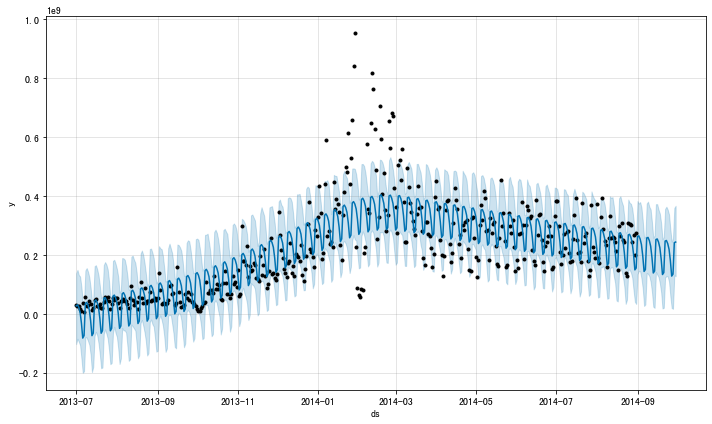

In [15]:
alg_purchase.plot(forcast_purchase);

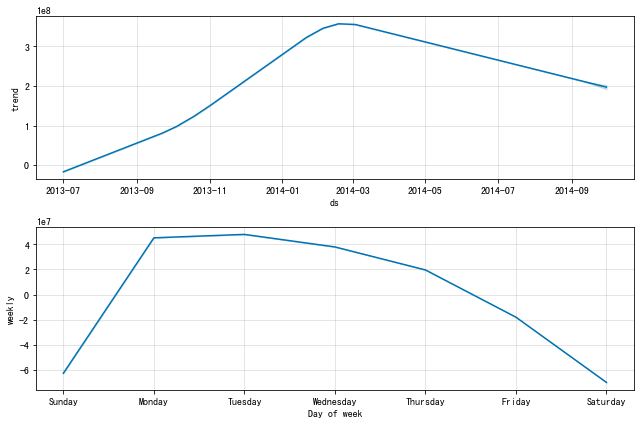

In [16]:
alg_purchase.plot_components(forcast_purchase);

In [17]:
pre_redeem = forcast_redeem[forcast_redeem['ds'] >= '2014-09-01'][['ds', 'yhat']]
pre_redeem.rename(columns={'yhat': 'redeem'}, inplace=True)
pre_redeem.head(3)

,ds,redeem
427,2014-09-01,3.367866e+08
428,2014-09-02,3.105321e+08
429,2014-09-03,3.128405e+08


In [18]:
pre_res = pre_purchase.merge(pre_redeem, on='ds')
pre_res.head()

,ds,purchase,redeem
0,2014-09-01,2.638201e+08,3.367866e+08
1,2014-09-02,2.657807e+08,3.105321e+08
2,2014-09-03,2.550672e+08,3.128405e+08
3,2014-09-04,2.360368e+08,2.941074e+08
4,2014-09-05,1.977252e+08,2.835456e+08


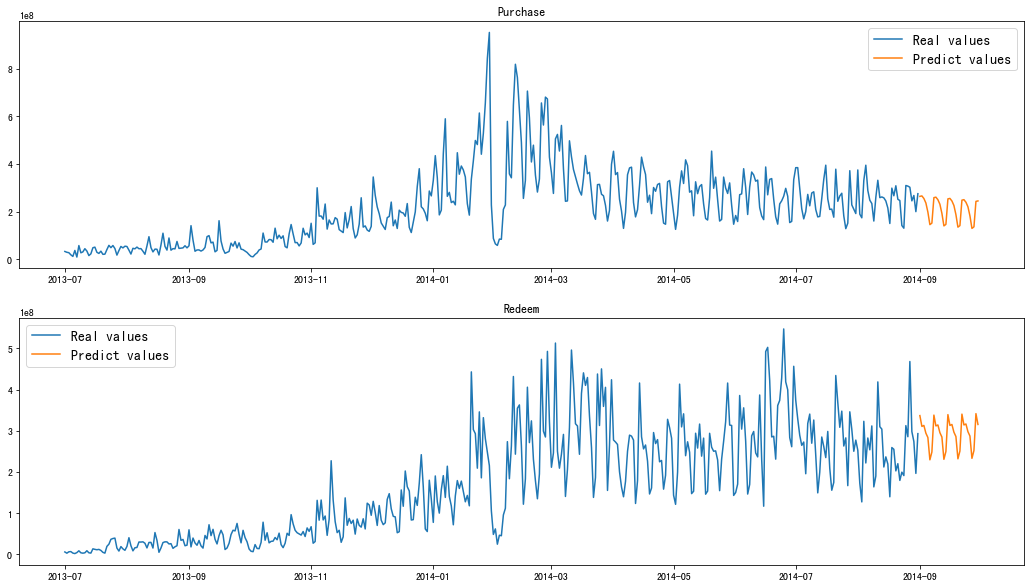

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(18, 10))
ax[0].plot(train['total_purchase_amt'], label='Real values')
ax[0].plot(pre_res['ds'], pre_res['purchase'], label='Predict values')
ax[0].set_title('Purchase')
ax[0].legend(fontsize=14)

ax[1].plot(train['total_redeem_amt'], label='Real values')
ax[1].plot(pre_res['ds'], pre_res['redeem'], label='Predict values')
ax[1].set_title('Redeem')
ax[1].legend(fontsize=14);

In [20]:
pre_res['ds'] = pre_res['ds'].dt.strftime('%Y%m%d')
pre_res.head()

,ds,purchase,redeem
0,20140901,2.638201e+08,3.367866e+08
1,20140902,2.657807e+08,3.105321e+08
2,20140903,2.550672e+08,3.128405e+08
3,20140904,2.360368e+08,2.941074e+08
4,20140905,1.977252e+08,2.835456e+08


In [63]:
pre_res.to_csv('./result/baseline_prophet.csv', header=None, index=None)

分数：77.2500
（如果加上月周期反而有所下跌几分）

In [21]:
train2 = train[train.index >= '20140301']
train2.head()

,total_purchase_amt,total_redeem_amt
report_date,,
2014-03-01,362865580,211279011
2014-03-02,276202230,246199417
2014-03-03,505305862,513017360
2014-03-04,524146340,250562978
2014-03-05,454295491,209072753


In [22]:
purchase = train2[['total_purchase_amt']]
purchase.reset_index(inplace=True)
purchase.columns = ['ds', 'y']
purchase.head(3)

,ds,y
0,2014-03-01,362865580
1,2014-03-02,276202230
2,2014-03-03,505305862


In [23]:
alg_purchase = Prophet(growth='linear', yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False,
                       seasonality_prior_scale=1)
# alg_purchase.add_seasonality('monthly', period=30.5, fourier_order=2)
alg_purchase.fit(purchase)
future_purchase = alg_purchase.make_future_dataframe(30)
forcast_purchase = alg_purchase.predict(future_purchase)
forcast_purchase.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-03-01,3.394586e+08,1.841187e+08,3.310783e+08,3.394586e+08,3.394586e+08,-8.176248e+07,-8.176248e+07,-8.176248e+07,-8.176248e+07,-8.176248e+07,-8.176248e+07,0.0,0.0,0.0,2.576961e+08
1,2014-03-02,3.385415e+08,1.889016e+08,3.311277e+08,3.385415e+08,3.385415e+08,-8.045908e+07,-8.045908e+07,-8.045908e+07,-8.045908e+07,-8.045908e+07,-8.045908e+07,0.0,0.0,0.0,2.580824e+08
2,2014-03-03,3.376244e+08,3.137396e+08,4.590305e+08,3.376244e+08,3.376244e+08,4.940456e+07,4.940456e+07,4.940456e+07,4.940456e+07,4.940456e+07,4.940456e+07,0.0,0.0,0.0,3.870289e+08


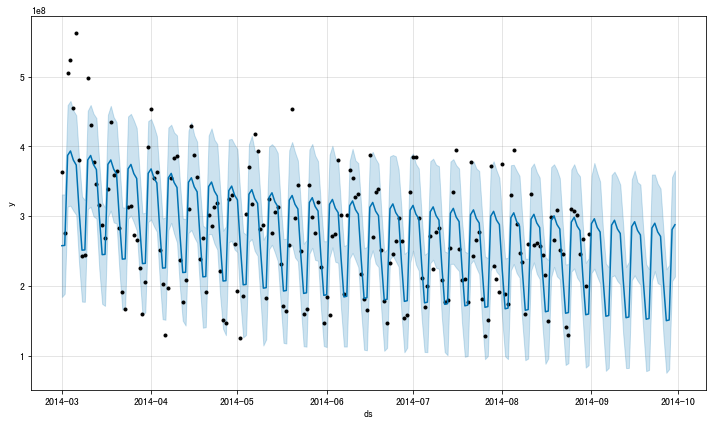

In [24]:
alg_purchase.plot(forcast_purchase);

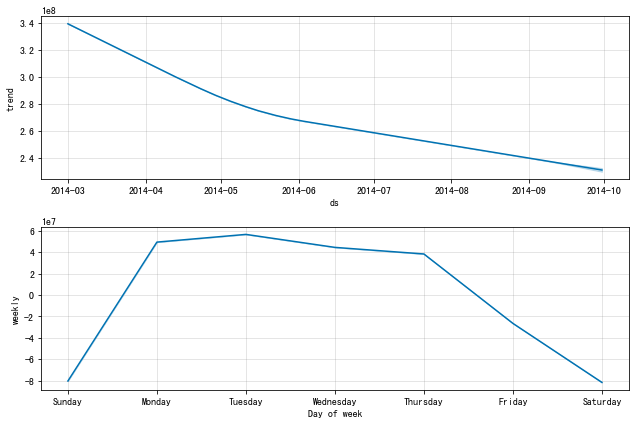

In [25]:
alg_purchase.plot_components(forcast_purchase);

In [26]:
pre_purchase = forcast_purchase[forcast_purchase['ds'] >= '2014-09-01'][['ds', 'yhat']]
pre_purchase.rename(columns={'yhat': 'purchase'}, inplace=True)
pre_purchase.head(3)

,ds,purchase
184,2014-09-01,2.893564e+08
185,2014-09-02,2.962632e+08
186,2014-09-03,2.838227e+08


In [28]:
redeem = train2[['total_redeem_amt']]
redeem.reset_index(inplace=True)
redeem.columns = ['ds', 'y']
redeem.head(3)

,ds,y
0,2014-03-01,211279011
1,2014-03-02,246199417
2,2014-03-03,513017360


In [30]:
alg_redeem = Prophet(growth='linear', yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False,
                       seasonality_prior_scale=1)
# alg_redeem.add_seasonality('monthly', period=30.5, fourier_order=2)
alg_redeem.fit(redeem)
future_redeem = alg_redeem.make_future_dataframe(30)
forcast_redeem = alg_redeem.predict(future_redeem)
forcast_redeem.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-03-01,2.836237e+08,8.951639e+07,2.814098e+08,2.836237e+08,2.836237e+08,-9.166500e+07,-9.166500e+07,-9.166500e+07,-9.166500e+07,-9.166500e+07,-9.166500e+07,0.0,0.0,0.0,1.919587e+08
1,2014-03-02,2.835332e+08,1.310789e+08,3.081629e+08,2.835332e+08,2.835332e+08,-6.631714e+07,-6.631714e+07,-6.631714e+07,-6.631714e+07,-6.631714e+07,-6.631714e+07,0.0,0.0,0.0,2.172161e+08
2,2014-03-03,2.834428e+08,2.604369e+08,4.334380e+08,2.834428e+08,2.834428e+08,6.988049e+07,6.988049e+07,6.988049e+07,6.988049e+07,6.988049e+07,6.988049e+07,0.0,0.0,0.0,3.533233e+08


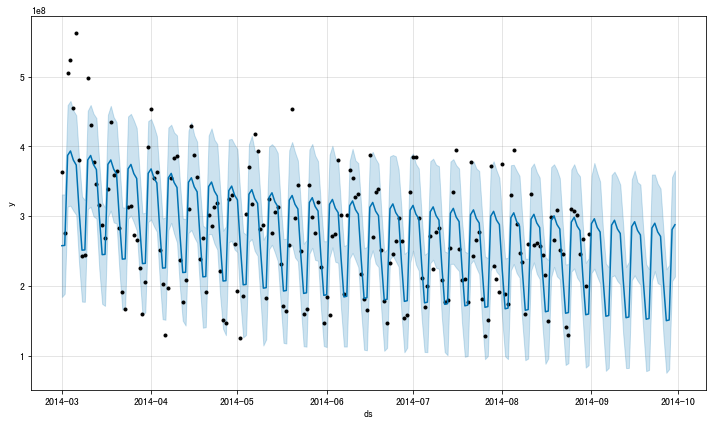

In [31]:
alg_purchase.plot(forcast_purchase);

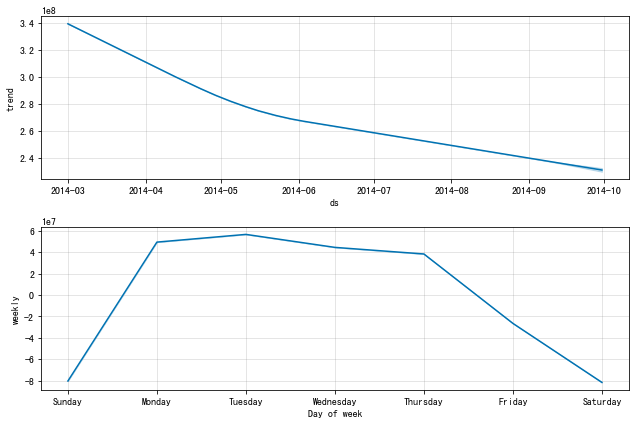

In [32]:
alg_purchase.plot_components(forcast_purchase);

In [33]:
pre_redeem = forcast_redeem[forcast_redeem['ds'] >= '2014-09-01'][['ds', 'yhat']]
pre_redeem.rename(columns={'yhat': 'redeem'}, inplace=True)
pre_redeem.head(3)

,ds,redeem
184,2014-09-01,3.373112e+08
185,2014-09-02,3.137499e+08
186,2014-09-03,3.098069e+08


In [34]:
pre_res = pre_purchase.merge(pre_redeem, on='ds')
pre_res.head()

,ds,purchase,redeem
0,2014-09-01,2.893564e+08,3.373112e+08
1,2014-09-02,2.962632e+08,3.137499e+08
2,2014-09-03,2.838227e+08,3.098069e+08
3,2014-09-04,2.773451e+08,2.737547e+08
4,2014-09-05,2.121566e+08,2.596429e+08


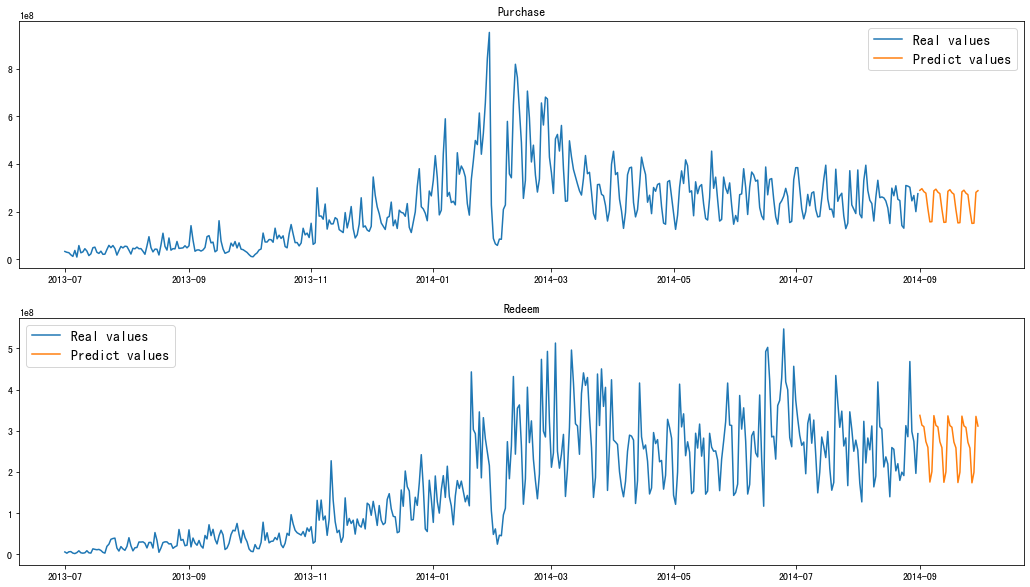

In [35]:
fig, ax = plt.subplots(2, 1, figsize=(18, 10))
ax[0].plot(train['total_purchase_amt'], label='Real values')
ax[0].plot(pre_res['ds'], pre_res['purchase'], label='Predict values')
ax[0].set_title('Purchase')
ax[0].legend(fontsize=14)

ax[1].plot(train['total_redeem_amt'], label='Real values')
ax[1].plot(pre_res['ds'], pre_res['redeem'], label='Predict values')
ax[1].set_title('Redeem')
ax[1].legend(fontsize=14);

In [36]:
pre_res['ds'] = pre_res['ds'].dt.strftime('%Y%m%d')
pre_res.head()

,ds,purchase,redeem
0,20140901,2.893564e+08,3.373112e+08
1,20140902,2.962632e+08,3.137499e+08
2,20140903,2.838227e+08,3.098069e+08
3,20140904,2.773451e+08,2.737547e+08
4,20140905,2.121566e+08,2.596429e+08


In [37]:
pre_res.to_csv('./result/baseline_prophet_2.csv', header=None, index=None)

分数：101.2402
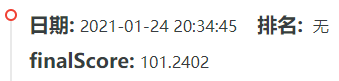